In [9]:
import glob 

import numpy as np

import jax.numpy as jnp

# plotting imports
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from copy import copy
params = {
   'axes.labelsize': 10,
   'font.size': 10,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'axes.titlesize':10,
   'text.usetex': True,
   'font.family':'serif',
   'font.serif':'Computer Modern'
   }
matplotlib.rcParams.update(params)
matplotlib.rcParams["font.serif"] = "Computer Modern Roman"
matplotlib.rcParams["font.family"] = "Serif"
matplotlib.rcParams['text.latex.preamble'] = r'\renewcommand{\mathdefault}[1][]{}'

from matplotlib.markers import MarkerStyle
import matplotlib as mpl

In [10]:
print(len(glob.glob("results_250609b/*.dat")))

data = np.array([np.genfromtxt(f) for f in np.sort(glob.glob("results_250609b/*.dat"))])

3000


In [11]:
data_sorted = data[np.argsort(data[:,0])]

indexes = np.argwhere(np.diff(data_sorted[:,0]) > 0)
indexes = np.append(indexes, len(data_sorted)-1)
indexes = indexes.flatten()

snrs = data_sorted[:,0][indexes].flatten()

means = []
photon_prob = []

counter = 0
mean_i = jnp.zeros(2)
photon_counts = 0
for i in range(len(data_sorted)):
    if i in indexes and i != 0:
        means.append(mean_i/counter)
        photon_prob.append(photon_counts/counter)
        counter = 0
        photon_counts = 0
        mean_i = jnp.zeros(2)
    mean_i += data_sorted[i,1:3]
    counter += 1

    if data_sorted[i,1] < 1.5e3:
        photon_counts += 1

means = np.array(means)
photon_prob = np.array(photon_prob)

In [12]:
photon_prob.shape

(30,)

In [13]:
dataset = np.genfromtxt(f'/home/ethan.payne/projects/GWPhotonCounting/projects/PM_EOS/hierarchical_EOS/bns_pm_dataset_MLE_250609.dat')

mtots, z, phi, psi, ra, dec, iota, f0_fit, gamma_fit, A_fit, phase_fit, snr, snr_sqz = dataset.T

In [14]:
from scipy.interpolate import interp1d
snr_array = np.logspace(-1,jnp.log10(6),100)

# cdf_CE1 = interp1d(np.sort(snr_data[:,-3]), np.linspace(1,0,len(snr_data)), fill_value=(1,0), bounds_error=False)(snr_array)
# cdf_CE2silica = interp1d(np.sort(snr_data[:,-2]), np.linspace(1,0,len(snr_data)), fill_value=(1,0), bounds_error=False)(snr_array)

In [15]:
from numpyro.distributions import Poisson

prob_photon = (1-np.exp(Poisson(snr_array**2/2).log_prob(0)))

In [16]:
prior_samples = np.random.uniform(1.5e3,4e3, (10000,2000))
min_prior = np.min(np.diff(np.percentile(prior_samples, [16,84], axis=1), axis=0))

min_prior = 0.68 * (4000 - 1500)

print(min_prior)

1700.0000000000002


In [17]:

from jax import random

samples = []

for i in range(10):
    samples_arr = Poisson(snr_array**2/2).sample(random.PRNGKey(np.random.randint(0,100000)), sample_shape=(100, 1000,))

    samples.append(samples_arr)

samples = jnp.concatenate(samples, axis=1)

/home/ethan.payne/.conda/envs/ve310/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


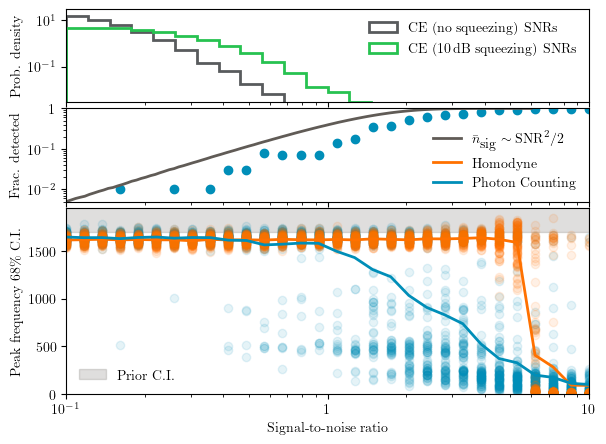

In [18]:
fig, ax = plt.subplots(3,1,figsize=(6.75,5), sharex=True, gridspec_kw={'height_ratios': [1, 1, 2], 'hspace':0.05})

ax[0].hist(snr, bins=np.logspace(-1,1,25), color="#585b5dff", histtype='step', lw=2, density=True, label=r'CE (no squeezing) SNRs')
ax[0].hist(snr_sqz, bins=np.logspace(-1,1,25), color="#27c250ff", histtype='step', lw=2, density=True, label=r'CE (10\,dB squeezing) SNRs')
ax[0].legend(frameon=False, loc='upper right')
ax[0].set_ylim(3e-3,3e1)
ax[0].set_ylabel('Prob. density')


ax[0].set_yscale('log')

ax[2].scatter(data[:,0], data[:,1], color='#008eb8ff', alpha=0.1, edgecolor=None)
ax[2].scatter(data[:,0], data[:,2], color='#ff7100ff', alpha=0.1, edgecolor=None)

ax[2].set_xscale('log')
ax[2].set_xlim(1e-1,10)
ax[2].set_ylim(0,1.95e3)

ax[1].semilogy(snr_array, np.mean(np.mean(samples > 0, axis=0), axis=0), color="#605B56", lw=2)
# ax[0].fill_between(snr_array, np.mean(np.mean(samples > 0, axis=0), axis=0) - 1.645*np.std(np.mean(samples > 0, axis=0), axis=0), 
#     np.mean(np.mean(samples > 0, axis=0), axis=0) + 1.645*np.std(np.mean(samples > 0, axis=0), axis=0), color='k', alpha=0.2)

ax[1].scatter(snrs, photon_prob, color='#008eb8ff')

legend_handles = [ 
    Line2D([0], [0], color="#605B56", lw=2, label=r'$\bar{n}_\textrm{sig}\sim\textrm{SNR}^2/2$'),
    Line2D([0], [0], color='#ff7100ff', lw=2, label=r'Homodyne'),
    Line2D([0], [0], color='#008eb8ff', lw=2, label=r'Photon Counting')
]

ax[1].set_ylim(5e-3,1)
ax[1].legend(handles=legend_handles, frameon=False, loc='lower right')
ax[1].set_ylabel(r'Frac. detected')
ax[2].set_xlabel(r'Signal-to-noise ratio')
ax[2].set_ylabel(r'Peak frequency 68\% C.I.')

ax[2].fill_between([0, 10], min_prior*jnp.ones(2), 2e3*jnp.ones(2), color="#605B56", label='Prior C.I.',zorder=-10, alpha=0.2)
ax[2].plot(snrs, means[:,1], color='#ff7100ff', lw=2)
ax[2].plot(snrs, means[:,0], color='#008eb8ff', lw=2)
ax[2].legend(frameon=False)

ax[2].set_xticks([1e-1, 1, 10])
ax[2].set_xticklabels([r'$10^{-1}$', r'$1$', r'$10$'])

ax[1].set_yticks([1e-2, 1e-1, 1])
ax[1].set_yticklabels([r'$10^{-2}$', r'$10^{-1}$', r'$1$'])

fig.savefig('snr_summary.pdf', bbox_inches='tight')

In [19]:
file_list = np.sort(glob.glob("results_250606/*.dat"))


In [20]:
file_list

array(['results_250606/summary_0.020000000000000004_0.dat',
       'results_250606/summary_0.020000000000000004_1.dat',
       'results_250606/summary_0.020000000000000004_10.dat', ...,
       'results_250606/summary_6.0_97.dat',
       'results_250606/summary_6.0_98.dat',
       'results_250606/summary_6.0_99.dat'], dtype='<U50')